### How emoji and word embedding helps to unveil emotional transitions during online messaging

####                                                         Moeen Mostafavi & Michael Porter

Engineering Systems and Environment, University of Virginia, Charlottesville, United States

{moeen,mdp2u}@virginia.edu

Please cite this work if you want to use the code:

Mostafavi, Moeen, and Michael D. Porter. "How emoji and word embedding helps to unveil emotional transitions during online messaging." 2021 IEEE International Systems Conference (SysCon). IEEE, 2021.

 <font color='blue'>
Note: This code was originally written in R, however, visualizing emojis in R was not easy. So we used python for visualization. This notebook uses both $Python$ and $R$ for simulation.

In [1]:
import pandas as pd
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from pylab import *
# !curl -O "https://raw.githubusercontent.com/vitorcurtis/RWinOut/master/RWinOut.py"
# %load_ext RWinOut
%load_ext rpy2.ipython

C:\ProgramData\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


You can access affective dictionaries from the following link:

http://affectcontroltheory.org/resources-for-researchers/data-sets-for-simulation/

To extend affective dictionary, we used the following one:

http://affectcontroltheory.org///usa-combined-surveyor-dictionary-2015/

     Smith-Lovin, Lynn, Dawn T. Robinson, Bryan C. Cannon, Jesse K. Clark, Robert Freeland, Jonathan H. Morgan and Kimberly B. Rogers. 2016. “Mean Affective Ratings of 929 Identities, 814 Behaviors, and 660 Modifiers by University of Georgia and Duke University Undergraduates and by Community Members in Durham, NC, in 2012-2014.” University of Georgia: Distributed at UGA Affect Control Theory Website: http://research.franklin.uga.edu/act/.

In the next chunk, we load data from these dictionaries. (Note that some words appear in two different categories of the dictionary. For example, $mother$ appears as $identity$ and $behavior$. This fact is a big limitation in the use of word embedding to find affective dictionaries. But at this point, we don't focus on this problem.

In [2]:
%%R 
library("ggplot2")
library('dplyr')   #

Combined_Surveyor_2015_modifier <- read.csv("http://affectcontroltheory.org///wp-content/uploads/2019/10/FullSurveyorInteract_Modifiers.csv",stringsAsFactor=F)
Combined_Surveyor_2015 <- read.csv("http://affectcontroltheory.org///wp-content/uploads/2019/10/FullSurveyorInteract_Identities.csv",stringsAsFactor=F)
Combined_Surveyor_2015_behaviors=read.csv("http://affectcontroltheory.org///wp-content/uploads/2019/10/FullSurveyorInteract_Behaviors.csv",stringsAsFactor=F)
Combined_Surveyor_2015_all=rbind(Combined_Surveyor_2015_behaviors,Combined_Surveyor_2015_modifier,Combined_Surveyor_2015)

s <-capture.output(summary(Combined_Surveyor_2015_all))

In [3]:
%R s

array(['     term                 E                  P                 A          ',
       ' Length:2403        Min.   :-4.26000   Min.   :-3.2600   Min.   :-2.8800  ',
       ' Class :character   1st Qu.:-1.68000   1st Qu.:-0.1250   1st Qu.:-0.3000  ',
       ' Mode  :character   Median : 0.28000   Median : 0.8700   Median : 0.3900  ',
       '                    Mean   : 0.05672   Mean   : 0.7444   Mean   : 0.3487  ',
       '                    3rd Qu.: 1.66000   3rd Qu.: 1.7000   3rd Qu.: 1.0850  ',
       '                    Max.   : 3.71000   Max.   : 3.7000   Max.   : 3.3000  ',
       '       E2                 P2                A2         ',
       ' Min.   :-4.26000   Min.   :-3.2600   Min.   :-2.8800  ',
       ' 1st Qu.:-1.68000   1st Qu.:-0.1250   1st Qu.:-0.3000  ',
       ' Median : 0.28000   Median : 0.8700   Median : 0.3900  ',
       ' Mean   : 0.05672   Mean   : 0.7444   Mean   : 0.3487  ',
       ' 3rd Qu.: 1.66000   3rd Qu.: 1.7000   3rd Qu.: 1.0850  ',
       ' 

Google News embedding can be downloaded from this link:

https://github.com/KnowledgeLab/GeometryofCulture

https://www.dropbox.com/s/5m9s5326off2lcg/google_news_embedding.zip?dl=0

Add normalization similar to the following ref.:

    Kozlowski, Austin C., Matt Taddy, and James A. Evans. "The geometry of culture: Analyzing the meanings of class through word embeddings." American Sociological Review 84.5 (2019): 905-949.

In [4]:
%%R 
df<-read.csv(file="D:/ACT/word embeding/GoogleNews_Embedding.csv", header=TRUE,row.names=1, sep=",")
df<-as.matrix(data.frame(df))

nrm <- function(x) x/(sqrt(sum(x^2)))
df<-t(apply(df,1,nrm))

### Finding the mapping from word-embedding to affective space

- Find the words that appear both in the affective dictionary and word-embedding
- Take 85% of the data as a training set and the rest for the test set
- Find $R$, which is the translation matrix
- Use $translated$ words as predictors in step-wise regression
- Check the correlation between $mapped data$ and affective meaning n the $test$ set.

In [5]:
%%R 
ACT_data_test=Combined_Surveyor_2015_all
# set.seed(500)
term_list=ACT_data_test$term
term_list=term_list[term_list %in% row.names(df)]

new_df=ACT_data_test[ACT_data_test$term %in% term_list,]
smp_size <- floor(0.85 * nrow(new_df))
set.seed(123)
train_ind <- sample(seq_len(nrow(new_df)), size = smp_size)
train2 <- new_df[train_ind, ]
test2 <- new_df[-train_ind, ]
## ***************************** Find the mapping **************
R=((solve((t(df[train2$term,]))%*%(df[train2$term,])))%*%(t(df[train2$term,])))%*%as.matrix(train2[,c('E','P','A')])
test2[,c('ER','PR','AR')]=df[test2$term,]%*%R
train2[,c('ER','PR','AR')]=df[train2$term,]%*%R

## ***************************** Regression on the mapping **************
model_E <- step(glm(E ~(ER+PR+AR)^2, data = train2), trace=0)  
test2$pred_E <- model_E %>% predict(test2)
model_P <- step(glm(P ~(ER+PR+AR)^2, data = train2), trace=0)
test2$pred_P <- model_P %>% predict(test2)
model <- step(glm(A ~(ER+PR+AR)^2, data = train2), trace=0)
test2$pred_A <- model %>% predict(test2)

s <-capture.output(cor(test2[,c("E","P",'A','pred_E','pred_P','pred_A')])[4:6,1:3])
s

In [6]:
%R s

array(['                  E         P            A',
       'pred_E  0.845601797 0.5461497 -0.009805026',
       'pred_P  0.538090440 0.7740176  0.244523722',
       'pred_A -0.005760882 0.2605709  0.677175956'], dtype='<U42')

### Customer interaction

We used $INTERACT$ to simulate the following interaction

          Heise, D. R. (2013). Interact guide. Department of Sociology, Indiana University.

| Index | Actor |Chat | Action | 
| --- | :- | :- | :- |
| 1 | Customer | Hello | greet |
| 2 | Salesman | Hello, I am the Bot | welcome |
| 3 | Customer | Why my order status is not updated | grouse at| 
| 4 | Salesman | What is your order number | question |
| 5 | Customer | order #8218 | answer | 
| 6 | Salesman | Please wait, I check it | request sth. from|
| 7 | Customer | Take your time | agree with|
| 8 | Salesman | We shipped it and will be delivered in two weeks | answer |
| 9 | Customer | Not acceptable, it is too late | criticize| 
| 10 | Salesman | Sorry, I can refund the shipping cost | gratify |
| 11 | Customer | I need full refund | argue with|
| 12 | Salesman | You get full refund in two business day| uplift |
| 13 | Customer | Sounds good | agree | 🙏
| 14 | Salesman | Thank you for contacting us| thank |
| 15 | Customer | Bye | leaves | 


### Affective mneaning of Emojis

\"Most pre-trained word embeddings contain few or no emoji representations. Emoji2vec provides pre-trained embeddings for all Unicode emojis which are learned from their description in the Unicode emoji standard. These pre-trained emoji embeddings map emoji symbols into the same 300-dimensional Google news word2vec embeddings and can thus be used in addition with the word2vec embeddings. This work was by developed Eisner, et al at University College London (UCL) in 2016. They have made their pre-trained emoji vectors available here.\"

Source: https://sqlthing.blogspot.com/2018/04/deep-learning-for-emojis-with-vs-code.html?m=0 

#### Emoji tags
| Index | Emoji |Tags| 
| --- | :- | :- |
| 1 |  😡|rage, irate, grumpy face, mad face, anger, pout,angry face, red face, pouting face|
| 2 | 😎|smooth,sun,sunny,sunglasses,sunnies,cool,smiling face with sunglasses,smiling,glasses,snapchat mutual best friends |
| 3 | 😒 |unamused, unamused face, lame, depressed, not amused, unhappy, unimpressed, disapprove, dissatisfied|
| 4 | 😫|tired face, exhausted, tired, fed up, sleepy |
| 5 | 😂|laughing, lol, laughing crying, tears, joy, happy, laughing tears, cry, face with tears of joy|
| 6 | 👎|down,thumb, hand, dislike, gesture, boo, stop, disapproval, sign, thumbs down sign, thumbs down, no |
| 7 | 😍|heart eyes,smile, flirt, heart face, love, smiling, lovestruck,heart|

Loading $emoji2vec$ in Python and export it to CSV format.

https://github.com/uclnlp/emoji2vec

    Eisner, Ben, Tim Rocktäschel, Isabelle Augenstein, Matko Bošnjak, and Sebastian Riedel. "emoji2vec: Learning emoji representations from their description." arXiv preprint arXiv:1609.08359 (2016).

In [7]:
w2v_model = KeyedVectors.load_word2vec_format('D:/ACT/emoji/1.emoji2vec/emoji2vec-master/pre-trained/emoji2vec.bin', binary=True)
print(len(w2v_model.index2word))

#np.savetxt("emoji2vec.csv", w2v_model.wv[w2v_model.wv.index2word], delimiter=",")
#with open("emoji2vec_list.txt", 'w', encoding='utf-8') as f:
 #   for s in w2v_model.wv.index2word:
#        f.write(str(s) + '\n')

1661


Loading $emoji2vec$ in R 

In [8]:
%%R 
w2v_model<-read.csv(file="D:/ACT/emoji/emoji2vec.csv", sep=",", header=FALSE) #, header=TRUE,row.names=1
w2v_names <- scan("D:/ACT/emoji/emoji2vec_list.txt", what="", sep="\n",encoding  = "UTF-8")
w2v_model<-t(apply(w2v_model,1,nrm))

We use the last model to find affective meaning of emojis: 

In [9]:
%%R 
tmp2= nrow(w2v_model)
emoji_epa <- data.frame(ER = character(tmp2), PR = numeric(tmp2), AR = numeric(tmp2))
emoji_epa[,c('ER','PR','AR')]=as.matrix(w2v_model)%*%as.matrix(R)

## ***************************** mapping only **************
emoji_epa$pred_E <- model_E %>% predict(emoji_epa)
emoji_epa$pred_P <- model_P %>% predict(emoji_epa)
emoji_epa$pred_A <- model %>% predict(emoji_epa)


write.csv(emoji_epa, "D:/ACT/emoji/emoji2vec_EPA2.csv")

In [10]:
#emoji2vec_EPA=pd.read_csv('D:/ACT/emoji/emoji2vec_EPA.csv')
emoji2vec_EPA=pd.read_csv('D:/ACT/emoji/emoji2vec_EPA2.csv')
emoji2vec_EPA['emoj']=w2v_model.index2word


The following chunk results in the table we had in our paper

In [11]:
tmp=['😎','😕','😃','😒','😫','👎', '🚶' ,'🙂','🤚','🙏🏽','😍', '😡' ,'☺️','🌝','😠','🌺','😖','😭','❤️','👊','🤢','💑','👂🏻','😛','😘','👹','💪','😪','⌛️']
tmp2=emoji2vec_EPA.loc[emoji2vec_EPA.emoj.isin(tmp),['emoj','pred_E','pred_P','pred_A'] ].copy()
tmp2.columns = ['Emoji','Evaluation', 'Potency',"Activity"]
tmp2=tmp2.sort_values(by=['Evaluation'], ascending=False)

round(tmp2,2)

,Emoji,Evaluation,Potency,Activity
1151,💑,3.95,3.63,0.69
305,😎,2.18,2.48,0.45
783,🌺,2.05,0.33,-0.69
250,🙂,1.95,1.10,-0.35
147,😃,1.89,2.26,0.95
1184,🤚,1.69,2.52,0.88
633,😘,1.58,2.23,0.66
686,😍,1.49,2.01,0.55
740,💪,1.35,2.37,0.83
1567,🙏🏽,0.78,1.90,-0.10


### Simulation

We shoud define $impression$ $change$ $eqation$ and $amalgamation$ equations for simulation. 

In [12]:
%%R 
next_state<-function(A_init,B_init,O_init,ABO){
ABO=unname(ABO)
B_init=unname(B_init)
A_init=unname(A_init)
O_init=unname(O_init)
B_init=as.numeric(B_init)
A_init=as.numeric(A_init)
O_init=as.numeric(O_init)
Ae = A_init[1]
Ap = A_init[2]
Aa = A_init[3]
Be = B_init[1]
Bp = B_init[2]
Ba = B_init[3]
Oe = O_init[1]
Op = O_init[2]
Oa = O_init[3]
rowss=c(A_init,B_init,O_init,Ae*Be , Ae*Op , Ap*Bp , Aa*Ba , Be*Oe , Be*Op , Bp*Oe , Bp*Op ,  Ae*Be*Oe , Ae*Be*Op  )
rowss=c(1,A_init,B_init,O_init,Ae*Be , Ae*Op , Ap*Bp , Aa*Ba , Be*Oe , Be*Op , Bp*Oe , Bp*Op ,  Ae*Be*Oe , Ae*Be*Op  )
A_final=as.matrix(t(ABO[1:20,2:4]))%*%as.matrix((rowss))
B_final=as.matrix(t(ABO[1:20,5:7]))%*%as.matrix((rowss))
O_final=as.matrix(t(ABO[1:20,8:10]))%*%as.matrix((rowss))
output=cbind(A_init,B_init,O_init,A_final,B_final,O_final)
colnames(output)=c("Ai","Bi","Oi","A","B","O")
row.names(output)=c("E","P","A")
return(t(output)) }

In [13]:
%%R 
amalgamate<-function(S_init,S_modif,amalgamate_i=amalgamate_f){
S_init=unname(S_init)
S_modif=unname(S_modif)
S_init=as.numeric(S_init)
S_modif=as.numeric(S_modif)
 Se = S_init[1]
 Sp = S_init[2]
 Sa = S_init[3]
 Me = S_modif[1]
 Mp = S_modif[2]
 Ma = S_modif[3]
rowss=c(1,S_modif,S_init,Se*Me, Sa*Me  )
S_final=as.matrix(t(amalgamate_i))%*%as.matrix((rowss))
row.names(S_final)=c("E","P","A")
return(t(S_final))}

Importing ABO equations imported from INTERACT software

    Heise, D. R. (2013). Interact guide. Department of Sociology, Indiana University.

In [14]:
%%R 
m_ABO<- read.table("D:/ACT/data/m_ABO.csv",stringsAsFactor=F)
f_ABO<- read.table("D:/ACT/data/f_ABO.csv",stringsAsFactor=F)
amalgamate_f=matrix(c(-0.36,.5,0,-.23,.46,0,0,.12,0,-.17,0,.32,.1,0,.55,0,0,.05,-.22,0,0,.44,-.05,0,.66,.02,.03), nrow = 9, ncol = 3)
amalgamate_m=matrix(c(-0.36,.5,0,-.23,.46,0,0,.12,0,-.17,0,.32,0,0,.62,0,0,.05,-.22,0,0,.44,-.05,0,.66,.02,.03), nrow = 9, ncol = 3)


### We  use emojis as modifiers

In [15]:
%R t(as.matrix(df['chatbot',]))%*%R

array([[1.92030537, 0.9065745 , 0.07204952]])

### Chatbot interaction

| Index | Actor |Chat | Action |Regular| Angry |Happy|
| --- | :- | :- | :- |---|---|---|
| 1 | Customer | Hello | greet | 😎|😕|😃|
| 2 | Chatbot | Hello, I am the Bot | welcome || ||
| 3 | Customer | Why my order status is not updated | grouse at| 😒 |😠|🙂|
| 4 | Chatbot | What is your order number | question || ||
| 5 | Customer | order #8218 | answer | 🌝 |😠|🙂|
| 6 | Chatbot | Please wait, I check it | request sth. from||||
| 7 | Customer | Take your time | agree with|☺️|🌝|😎|
| 8 | Chatbot | It will be delivered in two weeks | answer ||||
| 9 | Customer | Not acceptable, it is too late | criticize| 😫|😡|😕|
| 10 | Chatbot | Sorry, I can refund the shipping cost | gratify ||||
| 11 | Customer | I need full refund | argue with| 👎| 😒|😕|
| 12 | Chatbot | You get full refund in two business day| uplift || ||
| 13 | Customer | Sounds good | agree | 🙏🏽  |🙏🏽|😍|
| 14 | Chatbot | Thank you for contacting us| thank | |||
| 15 | Customer | Bye | leaves | 🚶 |🙂|🤚|


Regular customer

In [16]:
tmp=['😎','😒','🌝','☺️','😫','👎','🙏🏽','🚶']

tmp2=emoji2vec_EPA.loc[emoji2vec_EPA.emoj.isin(tmp),['emoj','pred_E','pred_P','pred_A'] ].copy()
tmp2.columns = ['Emoji','Evaluation', 'Potency',"Activity"]
tmp2=tmp2.sort_values(by=['Evaluation'], ascending=False)

tmp2

,Emoji,Evaluation,Potency,Activity
305,😎,2.178293,2.481963,0.449180
1567,🙏🏽,0.776568,1.903584,-0.098765
888,☺️,0.767798,1.307934,0.803226
61,🌝,0.697927,2.310001,1.011772
470,🚶,-0.173665,-0.089336,-0.686307
177,👎,-0.873020,1.763731,1.172877
532,😫,-1.289497,-1.355631,-1.997938
207,😒,-2.240586,-1.222034,-0.871604


We find the index of emojis from the above table and use it in the simulation.

In [17]:
%%R 
Dict_tmp =Combined_Surveyor_2015_behaviors
A_init=Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")]
O_init=t(as.matrix(df['chatbot',]))%*%R
B_init=Dict_tmp[Dict_tmp$term=='greet',c("E","P","A")]

step1_a_init=amalgamate(S_init=A_init,emoji_epa[306,c('pred_E','pred_P','pred_A')])
step1=next_state(step1_a_init,B_init,O_init,ABO=m_ABO)
step2=next_state(step1[6,],B_init=Dict_tmp[Dict_tmp$term=='welcome',c("E","P","A")],step1[4,],ABO=m_ABO)
step3_a_init=amalgamate(S_init=step2[6,],emoji_epa[208,c('pred_E','pred_P','pred_A')])
step3=next_state(step3_a_init,B_init=Dict_tmp[Dict_tmp$term=='grouse_at',c("E","P","A")],step2[4,],ABO=m_ABO)
step4_a_init=step3[6,]
step4=next_state(step4_a_init,B_init=Dict_tmp[Dict_tmp$term=='question',c("E","P","A")],step3[4,],ABO=m_ABO)
step5_a_init=amalgamate(S_init=step4[6,],emoji_epa[62,c('pred_E','pred_P','pred_A')])
step5=next_state(step5_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step4[4,],ABO=m_ABO)
step6=next_state(step5[6,],B_init=Dict_tmp[Dict_tmp$term=='request_something_from',c("E","P","A")],step5[1,],ABO=m_ABO)
step7_a_init=amalgamate(S_init=step6[6,],emoji_epa[889,c('pred_E','pred_P','pred_A')])
step7=next_state(step7_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step6[4,],ABO=m_ABO)
step8_a_init=step7[6,]
step8=next_state(step8_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step7[4,],ABO=m_ABO)
step9_a_init=amalgamate(S_init=step8[6,],emoji_epa[533,c('pred_E','pred_P','pred_A')])
step9=next_state(step9_a_init,B_init=Dict_tmp[Dict_tmp$term=='criticize',c("E","P","A")],step8[4,],ABO=m_ABO)
step10_a_init=step9[6,]
step10=next_state(step10_a_init,B_init=Dict_tmp[Dict_tmp$term=='gratify',c("E","P","A")],step9[4,],ABO=m_ABO)
step11_a_init=amalgamate(S_init=step10[6,],emoji_epa[178,c('pred_E','pred_P','pred_A')])
step11=next_state(step11_a_init,B_init=Dict_tmp[Dict_tmp$term=='argue_with',c("E","P","A")],step10[4,],ABO=m_ABO)
step12_a_init=step11[6,]
step12=next_state(step12_a_init,B_init=Dict_tmp[Dict_tmp$term=='uplift',c("E","P","A")],step11[4,],ABO=m_ABO)
step13_a_init=amalgamate(S_init=step12[6,],emoji_epa[1568,c('pred_E','pred_P','pred_A')])
step13=next_state(step13_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step12[4,],ABO=m_ABO)
step14_a_init=step13[6,]
step14=next_state(step14_a_init,B_init=Dict_tmp[Dict_tmp$term=='thank',c("E","P","A")],step13[4,],ABO=m_ABO)
step15_a_init=amalgamate(S_init=step14[6,],emoji_epa[471,c('pred_E','pred_P','pred_A')])
step15=next_state(step15_a_init,B_init=Dict_tmp[Dict_tmp$term=='leave',c("E","P","A")],step14[4,],ABO=m_ABO)

O_E=c(step1['O','E'],step2['A','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])-step1['Oi','E']
O_P=c(step1['O','P'],step2['A','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])-step1['Oi','P']
O_A=c(step1['O','A'],step2['A','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])-step1['Oi','A']

A_E=c(step1['A','E'],step2['O','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])-step1['Ai','E']
A_P=c(step1['A','P'],step2['O','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])-step1['Ai','P']
A_A=c(step1['A','A'],step2['O','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])-step1['Ai','A']



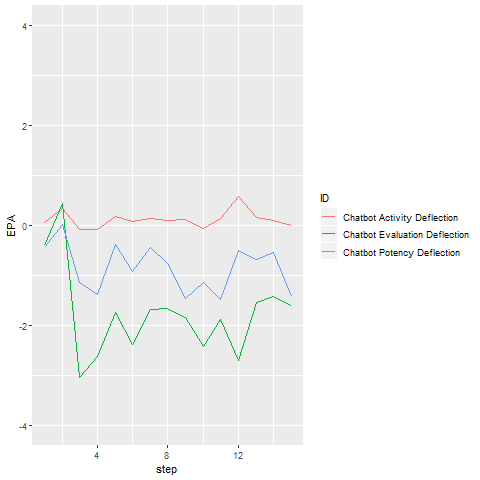

In [18]:
%%R

list_plot=list(O_E,O_P,O_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$ID = rep(c('Chatbot Evaluation Deflection','Chatbot Potency Deflection','Chatbot Activity Deflection'), sapply(list_plot, length))
ggplot(a_df, aes(x = step, y = EPA, color = ID)) + geom_line()+ coord_cartesian( ylim = c(-4, 4))


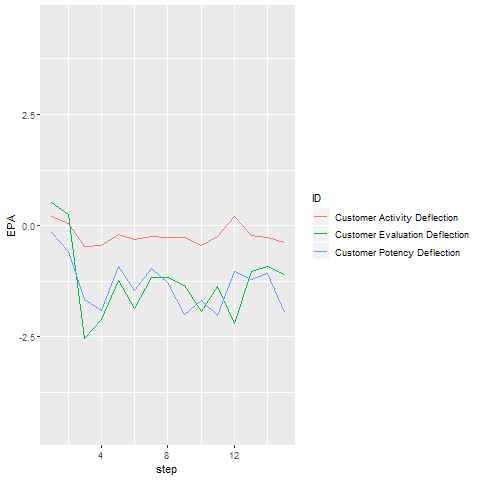

In [19]:
%%R
list_plot=list(A_E,A_P,A_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$ID = rep(c('Customer Evaluation Deflection','Customer Potency Deflection','Customer Activity Deflection'), sapply(list_plot, length))
ggplot(a_df, aes(x = step, y = EPA, color = ID)) + geom_line()+ coord_cartesian( ylim = c(-4.5, 4.5))


#### Let's do the same without modifiers:

In [20]:
%%R 
Dict_tmp =Combined_Surveyor_2015_behaviors
A_init=Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")]
O_init=t(as.matrix(df['chatbot',]))%*%R
B_init=Dict_tmp[Dict_tmp$term=='greet',c("E","P","A")]

step1_a_init=amalgamate(S_init=A_init,emoji_epa[306,c('pred_E','pred_P','pred_A')])
step1=next_state(step1_a_init,B_init,O_init,ABO=m_ABO)
step2=next_state(step1[6,],B_init=Dict_tmp[Dict_tmp$term=='welcome',c("E","P","A")],step1[4,],ABO=m_ABO)
step3_a_init=amalgamate(S_init=step2[6,],emoji_epa[208,c('pred_E','pred_P','pred_A')])
step3=next_state(step3_a_init,B_init=Dict_tmp[Dict_tmp$term=='grouse_at',c("E","P","A")],step2[4,],ABO=m_ABO)
step4_a_init=step3[6,]
step4=next_state(step4_a_init,B_init=Dict_tmp[Dict_tmp$term=='question',c("E","P","A")],step3[4,],ABO=m_ABO)
step5_a_init=amalgamate(S_init=step4[6,],emoji_epa[62,c('pred_E','pred_P','pred_A')])
step5=next_state(step5_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step4[4,],ABO=m_ABO)
step6=next_state(step5[6,],B_init=Dict_tmp[Dict_tmp$term=='request_something_from',c("E","P","A")],step5[1,],ABO=m_ABO)
step7_a_init=amalgamate(S_init=step6[6,],emoji_epa[889,c('pred_E','pred_P','pred_A')])
step7=next_state(step7_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step6[4,],ABO=m_ABO)
step8_a_init=step7[6,]
step8=next_state(step8_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step7[4,],ABO=m_ABO)
step9_a_init=amalgamate(S_init=step8[6,],emoji_epa[533,c('pred_E','pred_P','pred_A')])
step9=next_state(step9_a_init,B_init=Dict_tmp[Dict_tmp$term=='criticize',c("E","P","A")],step8[4,],ABO=m_ABO)
step10_a_init=step9[6,]
step10=next_state(step10_a_init,B_init=Dict_tmp[Dict_tmp$term=='gratify',c("E","P","A")],step9[4,],ABO=m_ABO)
step11_a_init=amalgamate(S_init=step10[6,],emoji_epa[178,c('pred_E','pred_P','pred_A')])
step11=next_state(step11_a_init,B_init=Dict_tmp[Dict_tmp$term=='argue_with',c("E","P","A")],step10[4,],ABO=m_ABO)
step12_a_init=step11[6,]
step12=next_state(step12_a_init,B_init=Dict_tmp[Dict_tmp$term=='uplift',c("E","P","A")],step11[4,],ABO=m_ABO)
step13_a_init=amalgamate(S_init=step12[6,],emoji_epa[1568,c('pred_E','pred_P','pred_A')])
step13=next_state(step13_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step12[4,],ABO=m_ABO)
step14_a_init=step13[6,]
step14=next_state(step14_a_init,B_init=Dict_tmp[Dict_tmp$term=='thank',c("E","P","A")],step13[4,],ABO=m_ABO)
step15_a_init=amalgamate(S_init=step14[6,],emoji_epa[471,c('pred_E','pred_P','pred_A')])
step15=next_state(step15_a_init,B_init=Dict_tmp[Dict_tmp$term=='leave',c("E","P","A")],step14[4,],ABO=m_ABO)

O_E=c(step1['Oi','E'],step1['O','E'],step2['A','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
O_P=c(step1['Oi','P'],step1['O','P'],step2['A','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
O_A=c(step1['Oi','A'],step1['O','A'],step2['A','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])

A_E=c(step1['Ai','E'],step1['A','E'],step2['O','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
A_P=c(step1['Ai','P'],step1['A','P'],step2['O','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
A_A=c(step1['Ai','A'],step1['A','A'],step2['O','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])

B_E=c(step1['Bi','E'],step1['B','E'],step2['B','E'],step3['B','E'],step4['B','E'],step5['B','E'],step6['B','E'],step7['B','E'],step8['B','E'],step9['B','E'],step10['B','E'],step11['B','E'],step12['B','E'],step13['B','E'],step14['B','E'],step15['B','E'])
B_P=c(step1['Bi','P'],step1['B','P'],step2['B','P'],step3['B','P'],step4['B','P'],step5['B','P'],step6['B','P'],step7['B','P'],step8['B','P'],step9['B','P'],step10['B','P'],step11['B','P'],step12['B','P'],step13['B','P'],step14['B','P'],step15['B','P'])
B_A=c(step1['Bi','A'],step1['B','A'],step2['B','A'],step3['B','A'],step4['B','A'],step5['B','A'],step6['B','A'],step7['B','A'],step8['B','A'],step9['B','A'],step10['B','A'],step11['B','A'],step12['B','A'],step13['B','A'],step14['B','A'],step15['B','A'])


O_E_change=as.numeric(na.omit(O_E-dplyr::lag(O_E)))
O_P_change=as.numeric(na.omit(O_P-dplyr::lag(O_P)))
O_A_change=as.numeric(na.omit(O_A-dplyr::lag(O_A)))
A_E_change=as.numeric(na.omit(A_E-dplyr::lag(A_E)))
A_P_change=as.numeric(na.omit(A_P-dplyr::lag(A_P)))
A_A_change=as.numeric(na.omit(A_A-dplyr::lag(A_A)))


In [21]:
%%R 
Dict_tmp =Combined_Surveyor_2015_behaviors
A_init=Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")]
O_init=t(as.matrix(df['chatbot',]))%*%R
B_init=Dict_tmp[Dict_tmp$term=='greet',c("E","P","A")]

step1=next_state(A_init,B_init,O_init,ABO=m_ABO)
step2=next_state(step1[6,],B_init=Dict_tmp[Dict_tmp$term=='welcome',c("E","P","A")],step1[4,],ABO=m_ABO)
step3=next_state(step2[6,],B_init=Dict_tmp[Dict_tmp$term=='grouse_at',c("E","P","A")],step2[4,],ABO=m_ABO)
step4=next_state(step3[6,],B_init=Dict_tmp[Dict_tmp$term=='question',c("E","P","A")],step3[4,],ABO=m_ABO)
step5=next_state(step4[6,],B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step4[4,],ABO=m_ABO)
step6=next_state(step5[6,],B_init=Dict_tmp[Dict_tmp$term=='request_something_from',c("E","P","A")],step5[1,],ABO=m_ABO)
step7=next_state(step6[6,],B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step6[4,],ABO=m_ABO)
step8=next_state(step7[6,],B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step7[4,],ABO=m_ABO)
step9=next_state(step8[6,],B_init=Dict_tmp[Dict_tmp$term=='criticize',c("E","P","A")],step8[4,],ABO=m_ABO)
step10=next_state(step9[6,],B_init=Dict_tmp[Dict_tmp$term=='gratify',c("E","P","A")],step9[4,],ABO=m_ABO)
step11=next_state(step10[6,],B_init=Dict_tmp[Dict_tmp$term=='argue_with',c("E","P","A")],step10[4,],ABO=m_ABO)
step12=next_state(step11[6,],B_init=Dict_tmp[Dict_tmp$term=='uplift',c("E","P","A")],step11[4,],ABO=m_ABO)
step13=next_state(step12[6,],B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step12[4,],ABO=m_ABO)
step14=next_state(step13[6,],B_init=Dict_tmp[Dict_tmp$term=='thank',c("E","P","A")],step13[4,],ABO=m_ABO)
step15=next_state(step14[6,],B_init=Dict_tmp[Dict_tmp$term=='leave',c("E","P","A")],step14[4,],ABO=m_ABO)

O_E2=c(step1['Oi','E'],step1['O','E'],step2['A','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
O_P2=c(step1['Oi','P'],step1['O','P'],step2['A','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
O_A2=c(step1['Oi','A'],step1['O','A'],step2['A','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])

A_E2=c(step1['Ai','E'],step1['A','E'],step2['O','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
A_P2=c(step1['Ai','P'],step1['A','P'],step2['O','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
A_A2=c(step1['Ai','A'],step1['A','A'],step2['O','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])

B_E2=c(step1['Bi','E'],step1['B','E'],step2['B','E'],step3['B','E'],step4['B','E'],step5['B','E'],step6['B','E'],step7['B','E'],step8['B','E'],step9['B','E'],step10['B','E'],step11['B','E'],step12['B','E'],step13['B','E'],step14['B','E'],step15['B','E'])
B_P2=c(step1['Bi','P'],step1['B','P'],step2['B','P'],step3['B','P'],step4['B','P'],step5['B','P'],step6['B','P'],step7['B','P'],step8['B','P'],step9['B','P'],step10['B','P'],step11['B','P'],step12['B','P'],step13['B','P'],step14['B','P'],step15['B','P'])
B_A2=c(step1['Bi','A'],step1['B','A'],step2['B','A'],step3['B','A'],step4['B','A'],step5['B','A'],step6['B','A'],step7['B','A'],step8['B','A'],step9['B','A'],step10['B','A'],step11['B','A'],step12['B','A'],step13['B','A'],step14['B','A'],step15['B','A'])


O_E2_change=as.numeric(na.omit(O_E2-dplyr::lag(O_E2)))
O_P2_change=as.numeric(na.omit(O_P2-dplyr::lag(O_P2)))
O_A2_change=as.numeric(na.omit(O_A2-dplyr::lag(O_A2)))
A_E2_change=as.numeric(na.omit(A_E2-dplyr::lag(A_E2)))
A_P2_change=as.numeric(na.omit(A_P2-dplyr::lag(A_P2)))
A_A2_change=as.numeric(na.omit(A_A2-dplyr::lag(A_A2)))



Happy customer

In [22]:
%%R 
Dict_tmp =Combined_Surveyor_2015_behaviors
A_init=Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")]
O_init=t(as.matrix(df['chatbot',]))%*%R
B_init=Dict_tmp[Dict_tmp$term=='greet',c("E","P","A")]

step1_a_init=amalgamate(S_init=A_init,emoji_epa[148,c('pred_E','pred_P','pred_A')])
step1=next_state(step1_a_init,B_init,O_init,ABO=m_ABO)
step2=next_state(step1[6,],B_init=Dict_tmp[Dict_tmp$term=='welcome',c("E","P","A")],step1[4,],ABO=m_ABO)
step3_a_init=amalgamate(S_init=step2[6,],emoji_epa[251,c('pred_E','pred_P','pred_A')])
step3=next_state(step3_a_init,B_init=Dict_tmp[Dict_tmp$term=='grouse_at',c("E","P","A")],step2[4,],ABO=m_ABO)
step4_a_init=step3[6,]
step4=next_state(step4_a_init,B_init=Dict_tmp[Dict_tmp$term=='question',c("E","P","A")],step3[4,],ABO=m_ABO)
step5_a_init=amalgamate(S_init=step4[6,],emoji_epa[251,c('pred_E','pred_P','pred_A')])
step5=next_state(step5_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step4[4,],ABO=m_ABO)
step6=next_state(step5[6,],B_init=Dict_tmp[Dict_tmp$term=='request_something_from',c("E","P","A")],step5[1,],ABO=m_ABO)
step7_a_init=amalgamate(S_init=step6[6,],emoji_epa[306,c('pred_E','pred_P','pred_A')])
step7=next_state(step7_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step6[4,],ABO=m_ABO)
step8_a_init=step7[6,]
step8=next_state(step8_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step7[4,],ABO=m_ABO)
step9_a_init=amalgamate(S_init=step8[6,],emoji_epa[35,c('pred_E','pred_P','pred_A')])
step9=next_state(step9_a_init,B_init=Dict_tmp[Dict_tmp$term=='criticize',c("E","P","A")],step8[4,],ABO=m_ABO)
step10_a_init=step9[6,]
step10=next_state(step10_a_init,B_init=Dict_tmp[Dict_tmp$term=='gratify',c("E","P","A")],step9[4,],ABO=m_ABO)
step11_a_init=amalgamate(S_init=step10[6,],emoji_epa[35,c('pred_E','pred_P','pred_A')])
step11=next_state(step11_a_init,B_init=Dict_tmp[Dict_tmp$term=='argue_with',c("E","P","A")],step10[4,],ABO=m_ABO)
step12_a_init=step11[6,]
step12=next_state(step12_a_init,B_init=Dict_tmp[Dict_tmp$term=='uplift',c("E","P","A")],step11[4,],ABO=m_ABO)
step13_a_init=amalgamate(S_init=step12[6,],emoji_epa[687,c('pred_E','pred_P','pred_A')])
step13=next_state(step13_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step12[4,],ABO=m_ABO)
step14_a_init=step13[6,]
step14=next_state(step14_a_init,B_init=Dict_tmp[Dict_tmp$term=='thank',c("E","P","A")],step13[4,],ABO=m_ABO)

step15_a_init=amalgamate(S_init=step14[6,],emoji_epa[1185,c('pred_E','pred_P','pred_A')])
step15=next_state(step15_a_init,B_init=Dict_tmp[Dict_tmp$term=='leave',c("E","P","A")],step14[4,],ABO=m_ABO)



O_E_H=c(step1['Oi','E'],step1['O','E'],step2['A','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
O_P_H=c(step1['Oi','P'],step1['O','P'],step2['A','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
O_A_H=c(step1['Oi','A'],step1['O','A'],step2['A','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])

A_E_H=c(step1['Ai','E'],step1['A','E'],step2['O','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['O','E'],step10['O','E'],step11['O','E'],step12['O','E'],step13['O','E'],step14['O','E'],step15['O','E'])
A_P_H=c(step1['Ai','P'],step1['A','P'],step2['O','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['O','P'],step10['O','P'],step11['O','P'],step12['O','P'],step13['O','P'],step14['O','P'],step15['O','P'])
A_A_H=c(step1['Ai','A'],step1['A','A'],step2['O','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['O','A'],step10['O','A'],step11['O','A'],step12['O','A'],step13['O','A'],step14['O','A'],step15['O','A'])


B_E_H=c(step1['Bi','E'],step1['B','E'],step2['B','E'],step3['B','E'],step4['B','E'],step5['B','E'],step6['B','E'],step7['B','E'],step8['B','E'],step9['B','E'],step10['B','E'],step11['B','E'],step12['B','E'],step13['B','E'],step14['B','E'],step15['B','E'])
B_P_H=c(step1['Bi','P'],step1['B','P'],step2['B','P'],step3['B','P'],step4['B','P'],step5['B','P'],step6['B','P'],step7['B','P'],step8['B','P'],step9['B','P'],step10['B','P'],step11['B','P'],step12['B','P'],step13['B','P'],step14['B','P'],step15['B','P'])
B_A_H=c(step1['Bi','A'],step1['B','A'],step2['B','A'],step3['B','A'],step4['B','A'],step5['B','A'],step6['B','A'],step7['B','A'],step8['B','A'],step9['B','A'],step10['B','A'],step11['B','A'],step12['B','A'],step13['B','A'],step14['B','A'],step15['B','A'])


O_E_H_change=as.numeric(na.omit(O_E_H-dplyr::lag(O_E_H)))
O_P_H_change=as.numeric(na.omit(O_P_H-dplyr::lag(O_P_H)))
O_A_H_change=as.numeric(na.omit(O_A_H-dplyr::lag(O_A_H)))
A_E_H_change=as.numeric(na.omit(A_E_H-dplyr::lag(A_E_H)))
A_P_H_change=as.numeric(na.omit(A_P_H-dplyr::lag(A_P_H)))
A_A_H_change=as.numeric(na.omit(A_A_H-dplyr::lag(A_A_H)))





Angry customer 

In [23]:
tmp=['😅','😢','🌺','😘','😕','😠', '🌝', '😡','😒', '🙏🏽', '🙂']

tmp2=emoji2vec_EPA.loc[emoji2vec_EPA.emoj.isin(tmp),['emoj','pred_E','pred_P','pred_A'] ].copy()
tmp2.columns = ['Emoji','Evaluation', 'Potency',"Activity"]
tmp2=tmp2.sort_values(by=['Evaluation'], ascending=False)

tmp2

,Emoji,Evaluation,Potency,Activity
783,🌺,2.051680,0.331765,-0.692770
250,🙂,1.952153,1.095938,-0.353486
633,😘,1.579295,2.225755,0.656216
1567,🙏🏽,0.776568,1.903584,-0.098765
61,🌝,0.697927,2.310001,1.011772
450,😅,-0.523085,0.434388,-0.381348
34,😕,-0.917981,-0.090738,-0.148879
908,😠,-2.021838,0.098667,1.064923
1001,😢,-2.110436,0.270396,0.008269
207,😒,-2.240586,-1.222034,-0.871604


In [24]:
%%R 

print(Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")])

Dict_tmp =Combined_Surveyor_2015_behaviors
A_init=Combined_Surveyor_2015[Combined_Surveyor_2015$term=='customer',c("E","P","A")]
O_init=t(as.matrix(df['chatbot',]))%*%R
B_init=Dict_tmp[Dict_tmp$term=='greet',c("E","P","A")]

step1_a_init=amalgamate(S_init=A_init,emoji_epa[35,c('pred_E','pred_P','pred_A')])
step1=next_state(step1_a_init,B_init,O_init,ABO=m_ABO)
step2=next_state(step1[6,],B_init=Dict_tmp[Dict_tmp$term=='welcome',c("E","P","A")],step1[4,],ABO=m_ABO)
step3_a_init=amalgamate(S_init=step2[6,],emoji_epa[909,c('pred_E','pred_P','pred_A')])
step3=next_state(step3_a_init,B_init=Dict_tmp[Dict_tmp$term=='grouse_at',c("E","P","A")],step2[4,],ABO=m_ABO)
step4_a_init=step3[6,]
step4=next_state(step4_a_init,B_init=Dict_tmp[Dict_tmp$term=='question',c("E","P","A")],step3[4,],ABO=m_ABO)
step5_a_init=amalgamate(S_init=step4[6,],emoji_epa[909,c('pred_E','pred_P','pred_A')])
step5=next_state(step5_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step4[4,],ABO=m_ABO)
step6=next_state(step5[6,],B_init=Dict_tmp[Dict_tmp$term=='request_something_from',c("E","P","A")],step5[1,],ABO=m_ABO)
step7_a_init=amalgamate(S_init=step6[6,],emoji_epa[62,c('pred_E','pred_P','pred_A')])
step7=next_state(step7_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step6[4,],ABO=m_ABO)
step8_a_init=step7[6,]
step8=next_state(step8_a_init,B_init=Dict_tmp[Dict_tmp$term=='answer',c("E","P","A")],step7[4,],ABO=m_ABO)
step9_a_init=amalgamate(S_init=step8[6,],emoji_epa[48,c('pred_E','pred_P','pred_A')])
step9=next_state(step9_a_init,B_init=Dict_tmp[Dict_tmp$term=='criticize',c("E","P","A")],step8[4,],ABO=m_ABO)
step10_a_init=step9[6,]
step10=next_state(step10_a_init,B_init=Dict_tmp[Dict_tmp$term=='gratify',c("E","P","A")],step9[4,],ABO=m_ABO)
step11_a_init=amalgamate(S_init=step10[6,],emoji_epa[208,c('pred_E','pred_P','pred_A')])
step11=next_state(step11_a_init,B_init=Dict_tmp[Dict_tmp$term=='argue_with',c("E","P","A")],step10[4,],ABO=m_ABO)
step12_a_init=step11[6,]
step12=next_state(step12_a_init,B_init=Dict_tmp[Dict_tmp$term=='uplift',c("E","P","A")],step11[4,],ABO=m_ABO)
step13_a_init=amalgamate(S_init=step12[6,],emoji_epa[1568,c('pred_E','pred_P','pred_A')])
step13=next_state(step13_a_init,B_init=Dict_tmp[Dict_tmp$term=='agree_with',c("E","P","A")],step12[4,],ABO=m_ABO)
step14_a_init=step13[6,]
step14=next_state(step14_a_init,B_init=Dict_tmp[Dict_tmp$term=='thank',c("E","P","A")],step13[4,],ABO=m_ABO)
step15_a_init=amalgamate(S_init=step14[6,],emoji_epa[62,c('pred_E','pred_P','pred_A')])
step15=next_state(step15_a_init,B_init=Dict_tmp[Dict_tmp$term=='leave',c("E","P","A")],step14[4,],ABO=m_ABO)

O_E_A=c(step1['Oi','E'],step1['O','E'],step2['A','E'],step3['O','E'],step4['A','E'],step5['O','E'],step6['A','E'],step7['O','E'],step8['A','E'],step9['O','E'],step10['A','E'],step11['O','E'],step12['A','E'],step13['O','E'],step14['A','E'],step15['O','E'])
O_P_A=c(step1['Oi','P'],step1['O','P'],step2['A','P'],step3['O','P'],step4['A','P'],step5['O','P'],step6['A','P'],step7['O','P'],step8['A','P'],step9['O','P'],step10['A','P'],step11['O','P'],step12['A','P'],step13['O','P'],step14['A','P'],step15['O','P'])
O_A_A=c(step1['Oi','A'],step1['O','A'],step2['A','A'],step3['O','A'],step4['A','A'],step5['O','A'],step6['A','A'],step7['O','A'],step8['A','A'],step9['O','A'],step10['A','A'],step11['O','A'],step12['A','A'],step13['O','A'],step14['A','A'],step15['O','A'])
A_E_A=c(step1['Ai','E'],step1['A','E'],step2['O','E'],step3['A','E'],step4['O','E'],step5['A','E'],step6['O','E'],step7['A','E'],step8['O','E'],step9['A','E'],step10['O','E'],step11['A','E'],step12['O','E'],step13['A','E'],step14['O','E'],step15['A','E'])
A_P_A=c(step1['Ai','P'],step1['A','P'],step2['O','P'],step3['A','P'],step4['O','P'],step5['A','P'],step6['O','P'],step7['A','P'],step8['O','P'],step9['A','P'],step10['O','P'],step11['A','P'],step12['O','P'],step13['A','P'],step14['O','P'],step15['A','P'])
A_A_A=c(step1['Ai','A'],step1['A','A'],step2['O','A'],step3['A','A'],step4['O','A'],step5['A','A'],step6['O','A'],step7['A','A'],step8['O','A'],step9['A','A'],step10['O','A'],step11['A','A'],step12['O','A'],step13['A','A'],step14['O','A'],step15['A','A'])
B_E_A=c(step1['Bi','E'],step1['B','E'],step2['B','E'],step3['B','E'],step4['B','E'],step5['B','E'],step6['B','E'],step7['B','E'],step8['B','E'],step9['B','E'],step10['B','E'],step11['B','E'],step12['B','E'],step13['B','E'],step14['B','E'],step15['B','E'])
B_P_A=c(step1['Bi','P'],step1['B','P'],step2['B','P'],step3['B','P'],step4['B','P'],step5['B','P'],step6['B','P'],step7['B','P'],step8['B','P'],step9['B','P'],step10['B','P'],step11['B','P'],step12['B','P'],step13['B','P'],step14['B','P'],step15['B','P'])
B_A_A=c(step1['Bi','A'],step1['B','A'],step2['B','A'],step3['B','A'],step4['B','A'],step5['B','A'],step6['B','A'],step7['B','A'],step8['B','A'],step9['B','A'],step10['B','A'],step11['B','A'],step12['B','A'],step13['B','A'],step14['B','A'],step15['B','A'])
O_E_A_change=as.numeric(na.omit(O_E_A-dplyr::lag(O_E_A)))
O_P_A_change=as.numeric(na.omit(O_P_A-dplyr::lag(O_P_A)))
O_A_A_change=as.numeric(na.omit(O_A_A-dplyr::lag(O_A_A)))
A_E_A_change=as.numeric(na.omit(A_E_A-dplyr::lag(A_E_A)))
A_P_A_change=as.numeric(na.omit(A_P_A-dplyr::lag(A_P_A)))
A_A_A_change=as.numeric(na.omit(A_A_A-dplyr::lag(A_A_A)))
B_E_A_change=as.numeric(na.omit(B_E_A-dplyr::lag(B_E_A)))
B_P_A_change=as.numeric(na.omit(B_P_A-dplyr::lag(B_P_A)))
B_A_A_change=as.numeric(na.omit(B_A_A-dplyr::lag(B_A_A)))


### Emotion change

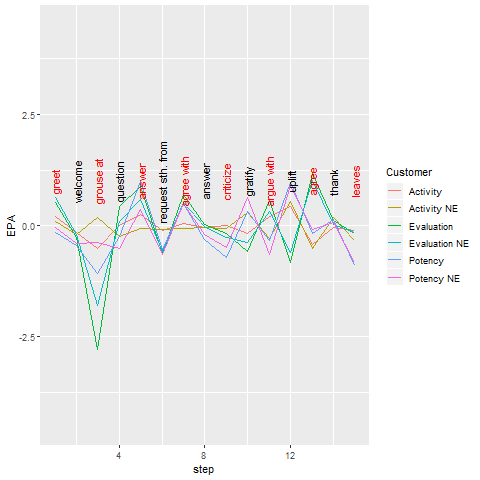

In [25]:
%%R
customer_actions=c('greet' ,'grouse at' ,'answer','agree with','criticize','argue with','agree','leaves')
chatbot_actions=c('welcome', 'question' , 'request sth. from','answer','gratify','uplift','thank')
#emoji_seq=c('😎','😒','🌝','☺️','😫','👎','🙏🏽','🚶')

list_plot=list(A_E_change,A_P_change,A_A_change,A_E2_change,A_P2_change,A_A2_change)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer= rep(c('Evaluation','Potency','Activity','Evaluation NE','Potency NE','Activity NE'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer)) + geom_line()+ coord_cartesian( ylim = c(-4.5, 4.5))+ 
        annotate("text",y=1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        #annotate("text",y=1,x=c(1,3,5,7,9,11,13,15), label = emoji_seq, color = "red",angle = 90)+
        annotate("text",y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)

                                

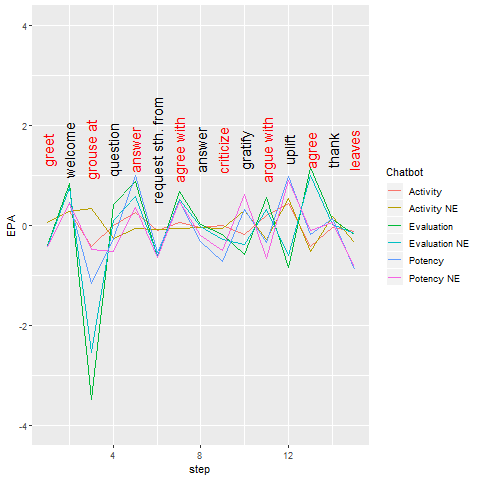

In [26]:
%%R

list_plot=list(O_E_change,O_P_change,O_A_change,O_E2_change,O_P2_change,O_A2_change)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Chatbot = rep(c('Evaluation','Potency','Activity','Evaluation NE','Potency NE','Activity NE'), sapply(list_plot, length))
ggplot(a_df, aes(x = step, y = EPA, color = Chatbot)) + geom_line()+ coord_cartesian( ylim = c(-4, 4))+
      annotate("text",size=5,y=1.5,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        #annotate("text",y=1,x=c(1,3,5,7,9,11,13,15), label = emoji_seq, color = "red",angle = 90)+
        annotate("text",size=5,y=1.5,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)



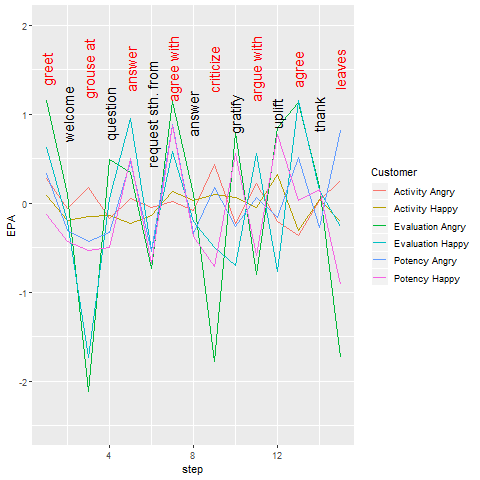

In [27]:
%%R
list_plot=list(A_E_H_change,A_P_H_change,A_A_H_change,A_E_A_change,A_P_A_change,A_A_A_change)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer= rep(c('Evaluation Happy','Potency Happy','Activity Happy','Evaluation Angry','Potency Angry','Activity Angry'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer)) + geom_line()+ coord_cartesian( ylim = c(-2.5, 2))+ 
        annotate("text",size=5,y=1.5,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)                                

### Emotions

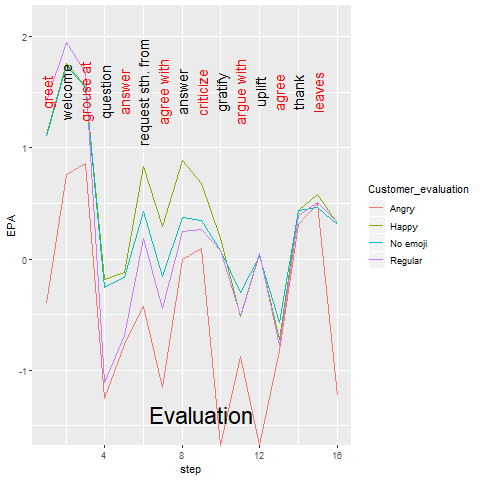

In [28]:
%%R
list_plot=list(A_E_H,A_E_A,A_E,A_E2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer_evaluation= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer_evaluation)) + geom_line()+ coord_cartesian( ylim = c(-1.5, 2.1))+ 
        annotate("text",y=1.5,x=c(1,3,5,7,9,11,13,15),size=5, label = customer_actions, color = "red",angle = 90)+
        annotate("text",y=1.5,x=c(2,4,6,8,10,12,14), size=5, label = chatbot_actions, color = "black",angle = 90)+
        annotate("text",y=-1.4,x=c(9), size=8, label = "Evaluation", color = "black")                               

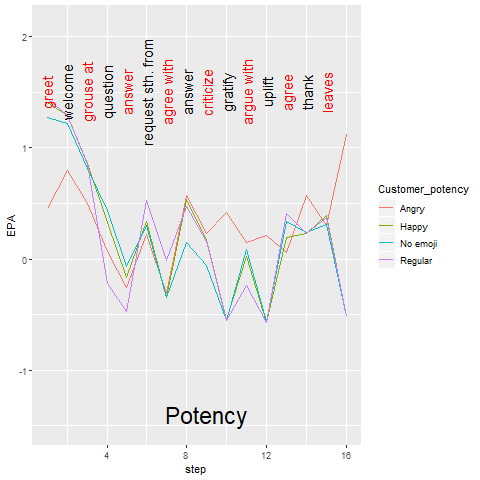

In [29]:
%%R
list_plot=list(A_P_H,A_P_A,A_P,A_P2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer_potency= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer_potency)) + geom_line()+ coord_cartesian( ylim = c(-1.5, 2.1))+ 
        annotate("text",size=5,y=1.5,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1.5,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
                                       annotate("text",y=-1.4,x=c(9), size=8, label = "Potency", color = "black")                               

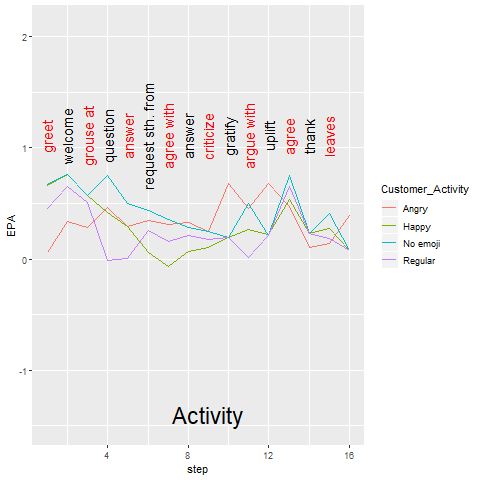

In [30]:
%%R
list_plot=list(A_A_H,A_A_A,A_A,A_A2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer_Activity= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer_Activity)) + geom_line()+ coord_cartesian( ylim = c(-1.5, 2.1))+ 
        annotate("text",size=5,y=1.1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1.1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
          annotate("text",y=-1.4,x=c(9), size=8, label = "Activity", color = "black")                               

## Chatbot

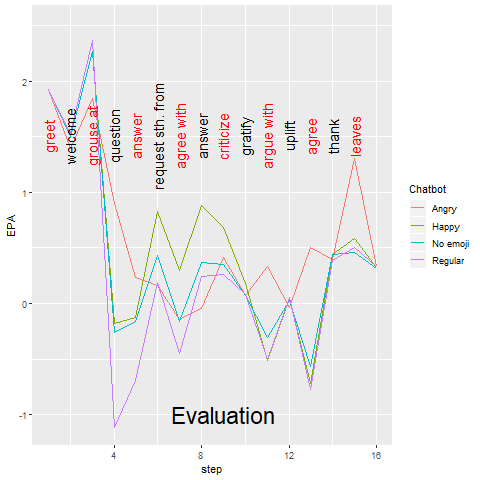

In [31]:
%%R
list_plot=list(O_E_H,O_E_A,O_E,O_E2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Chatbot= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Chatbot)) + geom_line()+ coord_cartesian( ylim = c(-1.1, 2.5))+ 
        annotate("text",size=5,y=1.5,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1.5,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
          annotate("text",y=-1,x=c(9), size=8, label = "Evaluation", color = "black")                               

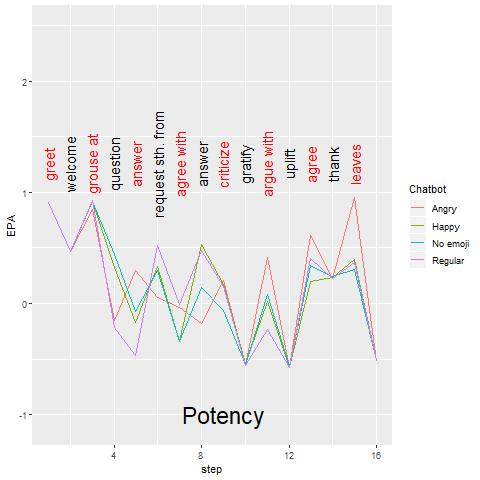

In [32]:
%%R
list_plot=list(O_P_H,O_P_A,O_P,O_P2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Chatbot= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Chatbot)) + geom_line()+ coord_cartesian( ylim = c(-1.1, 2.5))+ 
        annotate("text",size=5,y=1.25,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1.25,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
          annotate("text",y=-1,x=c(9), size=8, label = "Potency", color = "black")                               

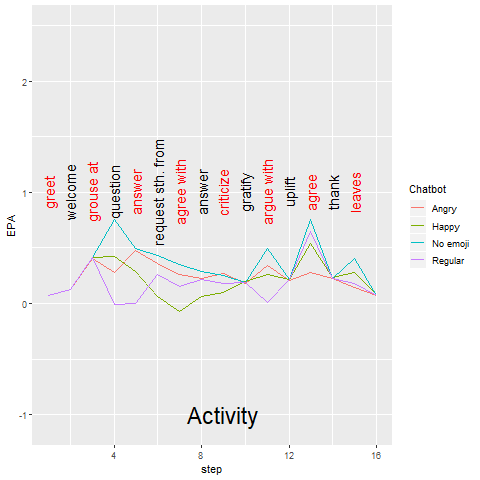

In [33]:
%%R
list_plot=list(O_A_H,O_A_A,O_A,O_A2)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Chatbot= rep(c('Happy','Angry','Regular','No emoji'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Chatbot)) + geom_line()+ coord_cartesian( ylim = c(-1.1, 2.5))+ 
        annotate("text",size=5,y=1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
          annotate("text",y=-1,x=c(9), size=8, label = "Activity", color = "black")                               

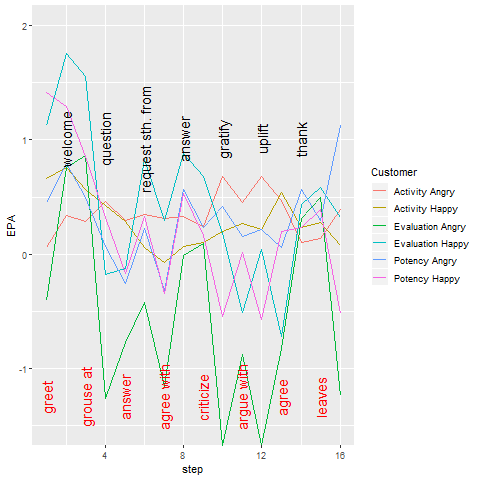

In [34]:
%%R
list_plot=list(A_E_H,A_P_H,A_A_H,A_E_A,A_P_A,A_A_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer= rep(c('Evaluation Happy','Potency Happy','Activity Happy','Evaluation Angry','Potency Angry','Activity Angry'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Customer)) + geom_line()+ coord_cartesian( ylim = c(-1.5, 2))+ 
        annotate("text",size=5,size=5,y=-1.25,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)                                

customer=[[   1.97   0.87   1.12],[   1.94   1.00   0.89]]
salesman=[[   0.07   0.52   1.98],[   1.35  -0.96   0.54]]

### Plot deflection

In [35]:
%%R
norm_vec <- function(x) sqrt(mean(x^2))
norm_vec(c(3,4))

In [36]:
%%R 
deflection_chatbot=sqrt(((O_E-O_E[1])^2+(O_P-O_P[1])^2+(O_A-O_A[1])^2))
deflection_chatbot_H=sqrt(((O_E_H-O_E_H[1])^2+(O_P_H-O_P_H[1])^2+(O_A_H-O_A_H[1])^2))
deflection_chatbot_A=sqrt(((O_E_A-O_E_A[1])^2+(O_P_A-O_P_A[1])^2+(O_A_A-O_A_A[1])^2))
deflection_chatbot_NE=sqrt(((O_E2-O_E2[1])^2+(O_P2-O_P2[1])^2+(O_A2-O_A2[1])^2))

deflection_customer=sqrt(((A_E-A_E[1])^2+(A_P-A_P[1])^2+(A_A-A_A[1])^2))
deflection_customer_H=sqrt(((A_E_H-A_E_H[1])^2+(A_P_H-A_P_H[1])^2+(A_A_H-A_A_H[1])^2))
deflection_customer_A=sqrt(((A_E_A-A_E_A[1])^2+(A_P_A-A_P_A[1])^2+(A_A_A-A_A_A[1])^2))
deflection_customer_NE=sqrt(((A_E2-A_E2[1])^2+(A_P2-A_P2[1])^2+(A_A2-A_A2[1])^2))

deflection_beh=sqrt(((B_E-B_E[1])^2+(B_P-B_P[1])^2+(B_A-B_A[1])^2))
deflection_beh_H=sqrt(((B_E_H-B_E_H[1])^2+(B_P_H-B_P_H[1])^2+(B_A_H-B_A_H[1])^2))
deflection_beh_A=sqrt(((B_E_A-B_E_A[1])^2+(B_P_A-B_P_A[1])^2+(B_A_A-B_A_A[1])^2))
deflection_beh_NE=sqrt(((B_E2-B_E2[1])^2+(B_P2-B_P2[1])^2+(B_A2-B_A2[1])^2))

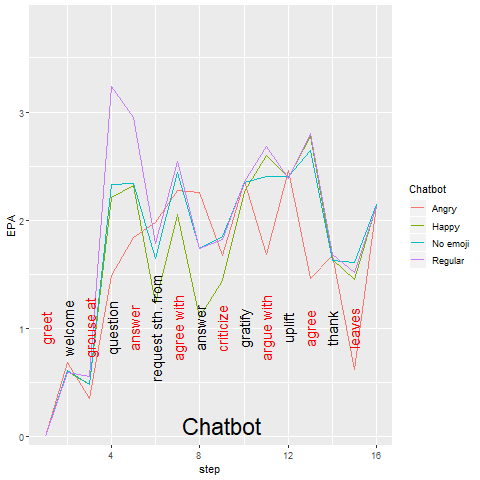

In [37]:
%%R
list_plot=list(deflection_chatbot,deflection_chatbot_NE,deflection_chatbot_H,deflection_chatbot_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Chatbot = rep(c('Regular','No emoji','Happy','Angry'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Chatbot)) + geom_line()+ coord_cartesian( ylim = c(0.1, 3.8))+
       annotate("text",size=5,y=1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
        annotate("text",y=0.1,x=c(9), size=8, label = "Chatbot", color = "black")                               

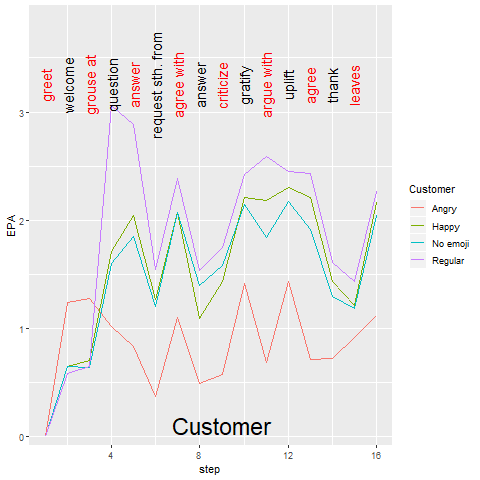

In [38]:
%%R
list_plot=list(deflection_customer,deflection_customer_NE,deflection_customer_H,deflection_customer_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Customer = rep(c('Regular','No emoji','Happy','Angry'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color =Customer)) + geom_line()+ coord_cartesian( ylim = c(0.1, 3.8))+
                annotate("text",size=5,y=3.25,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=3.25,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
      annotate("text",y=0.1,x=c(9), size=8, label = "Customer", color = "black")                               

In [39]:
%%R
deflection=(1/3)*(deflection_customer_A+deflection_beh_A+deflection_chatbot_A)

In [40]:
%%R
deflection_A=sqrt((deflection_customer_A)^2+(deflection_beh_A)^2+(deflection_chatbot_A)^2)
deflection_H=sqrt((deflection_customer_H)^2+(deflection_beh_H)^2+(deflection_chatbot_H)^2)
deflection_NE=sqrt((deflection_customer_NE)^2+(deflection_beh_NE)^2+(deflection_chatbot_NE)^2)
deflection=sqrt((deflection_customer)^2+(deflection_beh)^2+(deflection_chatbot)^2)

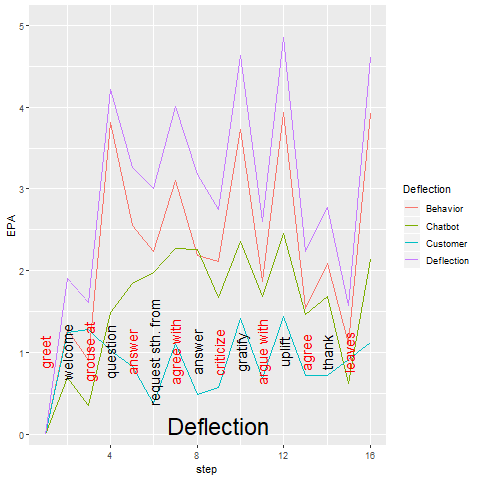

In [41]:
%%R

list_plot=list(deflection_A,deflection_customer_A,deflection_beh_A,deflection_chatbot_A)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), EPA =  x)))
a_df$Deflection = rep(c('Deflection','Customer','Behavior','Chatbot'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = EPA, color = Deflection)) + geom_line()+ coord_cartesian( ylim = c(0.1, 5))+
       annotate("text",size=5,y=1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)+
        annotate("text",y=0.1,x=c(9), size=8, label = "Deflection", color = "black")                               

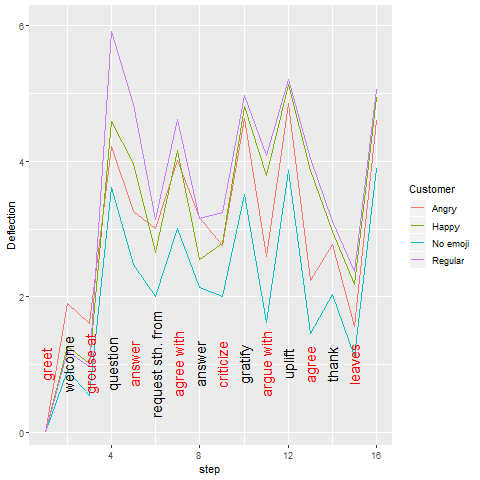

In [42]:
%%R

list_plot=list(deflection_A,deflection_H,deflection_beh_NE,deflection)
a_df = do.call("rbind", lapply(list_plot, function(x) data.frame(step =seq_along(x), Deflection =  x)))
a_df$Customer = rep(c('Angry','Happy','No emoji','Regular'), sapply(list_plot, length))
ggplot(a_df,size=6, aes(x = step, y = Deflection, color = Customer)) + geom_line()+ coord_cartesian( ylim = c(0.1, 6))+
       annotate("text",size=5,y=1,x=c(1,3,5,7,9,11,13,15), label = customer_actions, color = "red",angle = 90)+
        annotate("text",size=5,y=1,x=c(2,4,6,8,10,12,14), label = chatbot_actions, color = "black",angle = 90)


### Limitations

In [43]:
#pd.options.display.float_format = '{:,.2f}'.format

tmp=['💗','❤️']

tmp2=emoji2vec_EPA.loc[emoji2vec_EPA.emoj.isin(tmp),['emoj','pred_E','pred_P','pred_A'] ].copy()
tmp2.columns = ['Emoji','Evaluation', 'Potency',"Activity"]
tmp2=tmp2.sort_values(by=['Evaluation'], ascending=False)

tmp2
round(tmp2,2)

,Emoji,Evaluation,Potency,Activity
732,💗,2.59,2.69,0.10
368,❤️,0.27,2.66,0.03


### Finding tags associate with emojis in emoji2vec

In [44]:
# import codecs
url='https://raw.githubusercontent.com/uclnlp/emoji2vec/master/data/raw_training_data/emoji_joined.txt'
# doc = codecs.open(requests.get(url).text,'rU','UTF-8') #open for reading with "universal" type set
tmp = pd.read_csv(url, sep='\t',header=None).rename(columns={0:'keywords',1:'emoji'})


In [45]:
tmp[tmp.emoji=='❤️']

,keywords,emoji
976,love heart,❤️
977,red heart,❤️
978,death,❤️
979,intense,❤️
980,heavy black heart,❤️
981,cold,❤️
982,black,❤️
983,love,❤️
984,pink,❤️
985,romance,❤️


In [46]:
list(tmp[tmp.emoji=='❤️'].keywords)

['love heart',
 'red heart',
 'death',
 'intense',
 'heavy black heart',
 'cold',
 'black',
 'love',
 'pink',
 'romance',
 'passion',
 'heart',
 'evil',
 'desire',
 'red']

In [47]:
list(tmp[tmp.emoji=='💗'].keywords)

['growing heart', 'multiple heart', 'triple heart']

### Emoji tags
| Index | Emoji |Tags| 
| --- | :- | :- |
| 1 |  💗|growing heart, multiple heart, triple heart|
| 2 | ❤️|love heart, red heart, death, intense, heavy black heart, cold, black, love, pink, romance, passion, heart, evil, desire, red|




We can export other affective dictionaries from $INTERACT$ 

          Heise, D. R. (2013). Interact guide. Department of Sociology, Indiana University.

In [48]:
%%R 
texas1998_modifier<- read.csv("D:/ACT/data/texas1998_modifier.csv",stringsAsFactor=F)
texas1998_behaviors<- read.csv("D:/ACT/data/texas1998_behaviors.csv",stringsAsFactor=F)
texas1998_identities<- read.csv("D:/ACT/data/texas1998_identities.csv",stringsAsFactor=F)
texas1998_all=rbind(texas1998_behaviors,texas1998_modifier,texas1998_identities)

s <-capture.output(cor(merge(texas1998_all,Combined_Surveyor_2015_all,by="term")[,c("E.x","P.x",'A.x',"E.y",'P.y',"A.y")])[1:3,4:6])
print_tmp=cor(merge(texas1998_all,Combined_Surveyor_2015_all,by="term")[,c("E.x","P.x",'A.x',"E.y",'P.y',"A.y")])[1:3,4:6]
#s
print_tmp